# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [1]:
!pip install numpy pandas yfinance matplotlib PyPortfolioOpt
import os
# if not os.path.isdir('data'):
#     os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
#     os.chdir('PyPortfolioOpt/cookbook')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [22]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']

In [23]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AAPL,CVX,GE,GOOG,JNJ,MSFT,PFE,PG,WFC,XOM
Date,,,,,,,,,,
2023-04-26,163.759995,165.979996,96.209999,104.449997,162.619995,295.369995,38.630001,154.580002,39.459999,115.449997
2023-04-27,168.410004,166.949997,98.059998,108.370003,163.000000,304.829987,38.740002,156.470001,39.660000,116.830002
2023-04-28,169.679993,168.580002,98.970001,108.220001,163.699997,307.260010,38.889999,156.380005,39.750000,118.339996
2023-05-01,169.589996,167.240005,101.180000,107.709999,163.600006,305.559998,39.209999,156.570007,40.389999,114.669998
2023-05-02,168.539993,160.039993,101.510002,105.980003,165.029999,305.410004,39.060001,156.429993,38.840000,110.099998


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.122343
1993-02-01    25.301016
1993-02-02    25.354622
1993-02-03    25.622629
1993-02-04    25.729843
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2666622877696,
 'MSFT': 2270872993792,
 'GOOG': 1342204936192,
 'JNJ': 514867200000,
 'XOM': 445134307328,
 'PG': 368700784640,
 'CVX': 303218163712,
 'PFE': 220470280192,
 'WFC': 148904787968,
 'GE': 110674321408}

## Constructing the prior

In [7]:
import pypfopt
pypfopt.__version__

'1.5.4'

In [9]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.5294007114412893

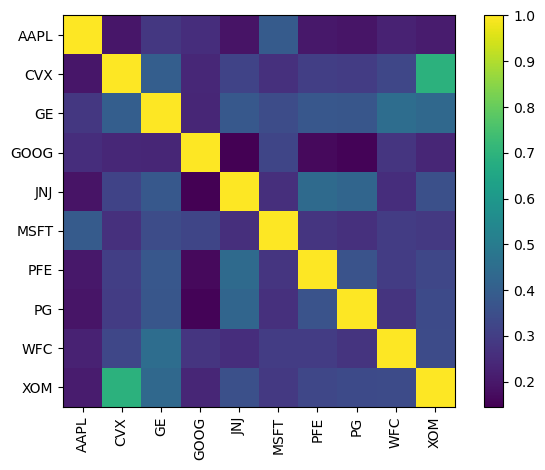

In [10]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL    0.175789
CVX     0.071492
GE      0.083161
GOOG    0.060075
JNJ     0.064146
MSFT    0.115448
PFE     0.067033
PG      0.059932
WFC     0.079503
XOM     0.069061
dtype: float64

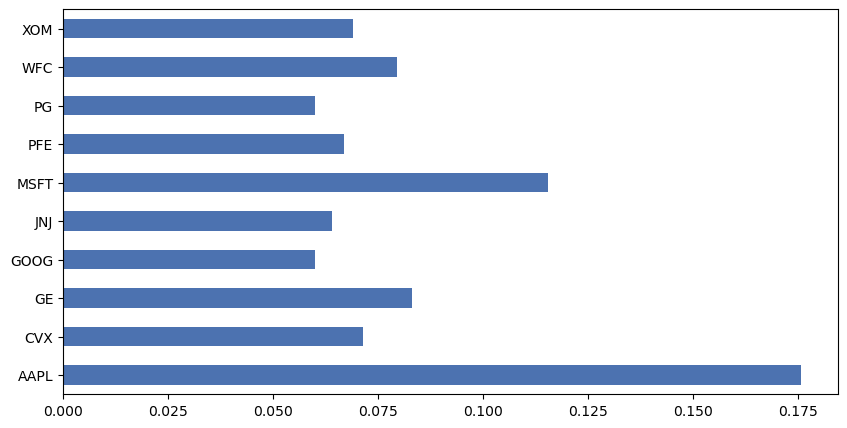

In [12]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [25]:
# You don't have to provide views on all the assets
# ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'PG', 'CVX', 'PFE', 'WFC', 'GE']
viewdict = {
    "AAPL": 0.06,
    "MSFT": 0.20,
    "GOOG": 0.10,
    "JNJ": 0.05,
    "XOM": 0.04,
    "PG": -0.02,  # I think Coca-Cola will go down 5%
    "CVX": 0.02,
    "PFE": 0.08,
    "WFC": 0.03,  # but low confidence, which will be reflected later
    "GE": 0.06
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [50]:
confidences = [
    0.6,
    0.6,
    0.2,
    0.5,
    0.5, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]
confidences2 = np.linalg.inv(np.dot(0.25, S))
confidences2

array([[ 35.92146997,  -0.63362632,  -5.18059168,  -8.78959326,
         -1.05138122, -14.22871182,  -1.40644693,  -1.73537037,
         -1.56417084,  -0.73368515],
       [ -0.63362632, 121.41915813,  -7.51678335,  -9.12263342,
         -4.3050052 ,  -1.46207865,  -4.10753005,  -2.62678225,
         -4.97353671, -82.01702323],
       [ -5.18059168,  -7.51678335,  85.81314796,  -2.69042165,
        -11.33350998,  -7.7402323 ,  -9.74476201, -12.21020782,
        -18.44003682, -14.31706652],
       [ -8.78959326,  -9.12263342,  -2.69042165, 163.99596947,
          2.04028292, -20.79476415,  -0.45309454,   0.34540341,
        -13.38160072,  -5.02107232],
       [ -1.05138122,  -4.3050052 , -11.33350998,   2.04028292,
        110.34174496,  -4.48345958, -25.62664606, -26.52177863,
         -0.30484392, -10.608526  ],
       [-14.22871182,  -1.46207865,  -7.7402323 , -20.79476415,
         -4.48345958,  79.72775466,  -6.20112788,  -6.08915526,
         -5.02127793,  -4.61036561],
       [ -

In [27]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

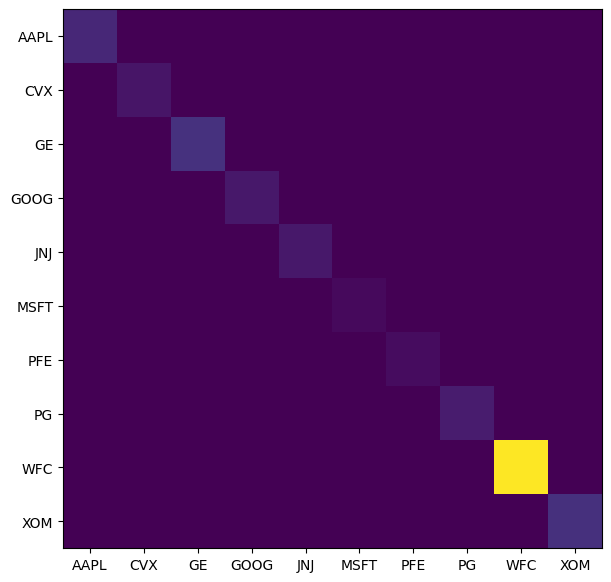

In [28]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [29]:
np.diag(bl.omega)

array([0.00461445, 0.00231688, 0.00585427, 0.0026461 , 0.00264868,
       0.00098799, 0.0014208 , 0.00315536, 0.04119731, 0.00564844])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [30]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [31]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [32]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [33]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.132066
CVX     0.035412
GE      0.058901
GOOG    0.042753
JNJ     0.044656
MSFT    0.101840
PFE     0.074220
PG      0.016785
WFC     0.057012
XOM     0.039954
dtype: float64

We can visualise how this compares to the prior and our views:

In [34]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.175789,0.132066,0.06
CVX,0.071492,0.035412,0.02
GE,0.083161,0.058901,0.06
GOOG,0.060075,0.042753,0.10
JNJ,0.064146,0.044656,0.05
MSFT,0.115448,0.101840,0.20
PFE,0.067033,0.074220,0.08
PG,0.059932,0.016785,-0.02
WFC,0.079503,0.057012,0.03
XOM,0.069061,0.039954,0.04


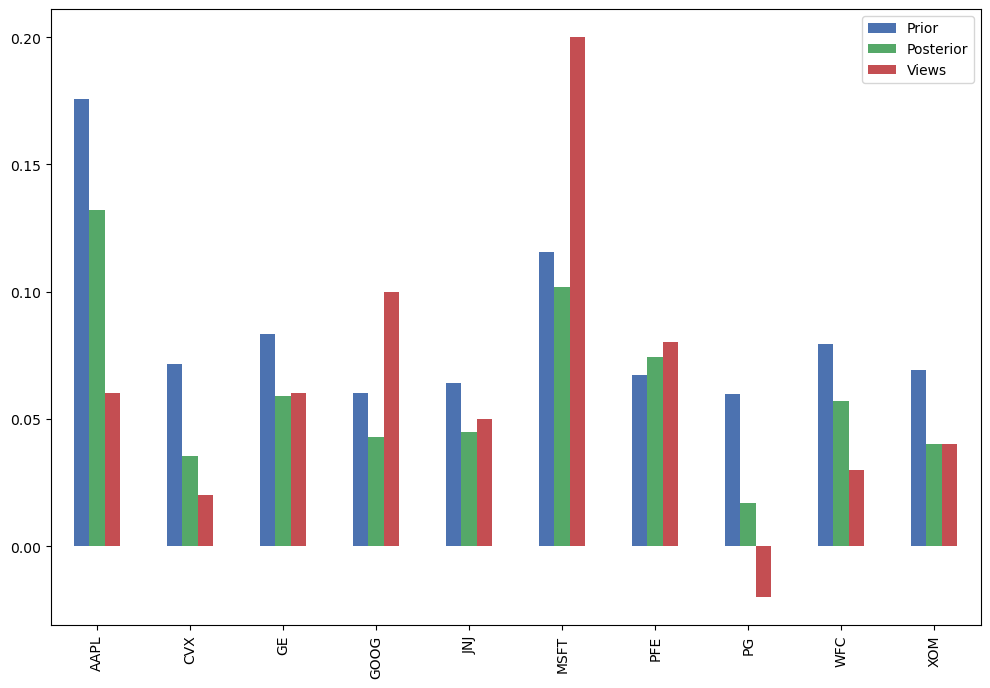

In [35]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

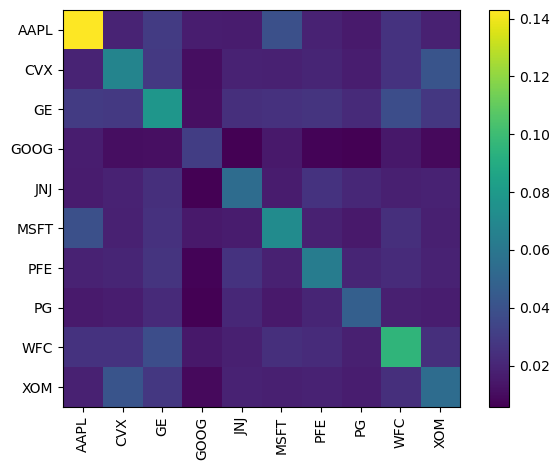

In [36]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [47]:
from pypfopt import EfficientFrontier, objective_functions

In [48]:
# def sum(w):
#     np.sum


InstantiationError: The objective function was changed after the initial optimization. Please create a new instance instead.

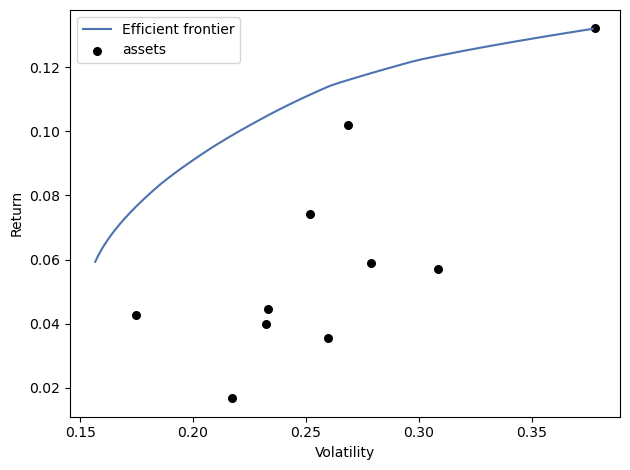

In [49]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w[0]+w[1]+w[2]+w[3]+w[4]+w[5]+w[6]+w[7]+w[8]+w[9] == 1)
ef.add_objective(objective_functions.L2_reg)
plotting.plot_efficient_frontier(ef)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
cleaned_weights

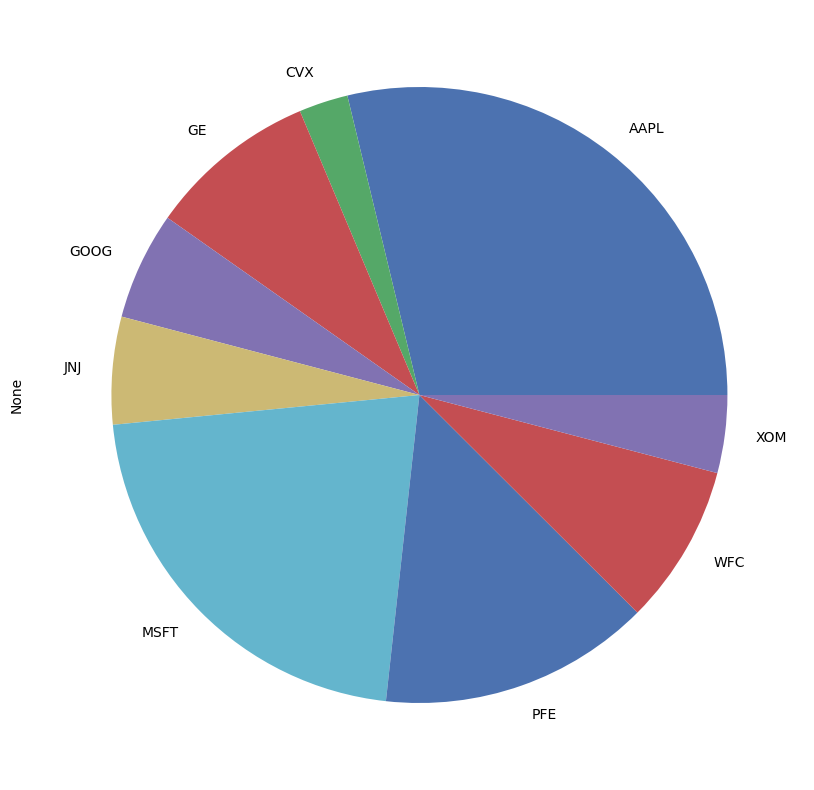

In [39]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [40]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $73.41


/Users/ygsharma/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': 34,
 'CVX': 3,
 'GE': 18,
 'GOOG': 11,
 'JNJ': 7,
 'MSFT': 14,
 'PFE': 73,
 'WFC': 43,
 'XOM': 7}